In [1]:
import os
import sys

current_dir = os.getcwd()
src_path = os.path.join(current_dir, "../src-python")

if src_path not in sys.path:
    sys.path.append(src_path)

In [2]:
import cv2
import supervision as sv
from app.analysis.yard_line_detection import detect_yard_lines
from app.analysis.hash_mark_detection import detect_hash_marks
from app.analysis.player_detection import detect_players
from app.analysis.field_boundaries import process_full_field_bounds
from app.analysis.perspective_transform import transform_image
from app.analysis.field_positioning import classify_yard_lines_and_los
from app.analysis.formation_classifier import classify_formation
from app.analysis.artificial_pitch import draw_positions_on_artificial_pitch

In [3]:
GAME = "2108 BOISE STATE OFF vs COLORADO STATE"
PLAY = "021"
SNAP = 3

IMAGE_PATH = f"{src_path}/resources/games/{GAME}/snaps/play_{PLAY}_snap{SNAP}.jpg"
OUTPUT_DIR = f"{src_path}/resources/games/{GAME}/analysis"
os.makedirs(OUTPUT_DIR, exist_ok=True)

if not os.path.exists(IMAGE_PATH):
    raise FileNotFoundError(f"Image not found: {IMAGE_PATH}")

In [4]:
input_filename = os.path.basename(IMAGE_PATH)
input_name, _ = os.path.splitext(input_filename)

yard_lines_img = os.path.join(OUTPUT_DIR, f"{input_name}_DEBUG_yard_lines.jpg")
hash_marks_img = os.path.join(OUTPUT_DIR, f"{input_name}_DEBUG_hash_marks.jpg")
player_detections_img = os.path.join(OUTPUT_DIR, f"{input_name}_player_detection.jpg")
field_boundaries_img = os.path.join(OUTPUT_DIR, f"{input_name}_DEBUG_field_boundaries.jpg")
top_down_perspective = os.path.join(OUTPUT_DIR, f"{input_name}_DEBUG_top_down.jpg")
annotated_top_down = os.path.join(OUTPUT_DIR, f"{input_name}_annotated_top_down.jpg")
classified_yard_lines = os.path.join(OUTPUT_DIR, f"{input_name}_DEBUG_classified_yard_lines.jpg")
formation_result = os.path.join(OUTPUT_DIR, f"{input_name}_formation.json")
artificial_pitch = os.path.join(OUTPUT_DIR, f"{input_name}_top_down_artificial.jpg")

Mid Xs: [np.float64(13.261708862114208), np.float64(223.53180468831027), np.float64(436.4000880942973), np.float64(649.2764459466102), np.float64(864.4714061426159), np.float64(1082.7638431245703), np.float64(1304.19878514047)]


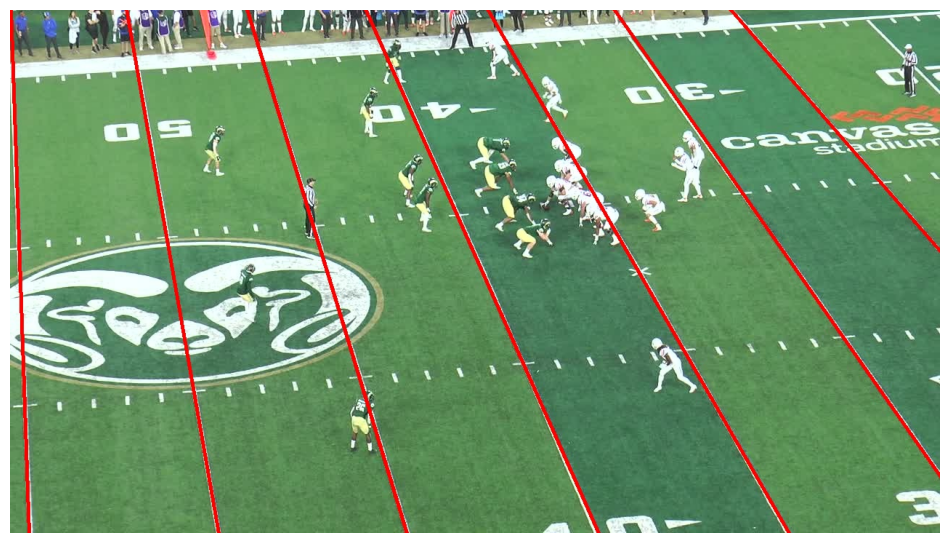

In [5]:
yard_lines = detect_yard_lines(IMAGE_PATH, yard_lines_img, max_degree=60)
yard_lines_vis = cv2.imread(yard_lines_img)
sv.plot_image(yard_lines_vis)

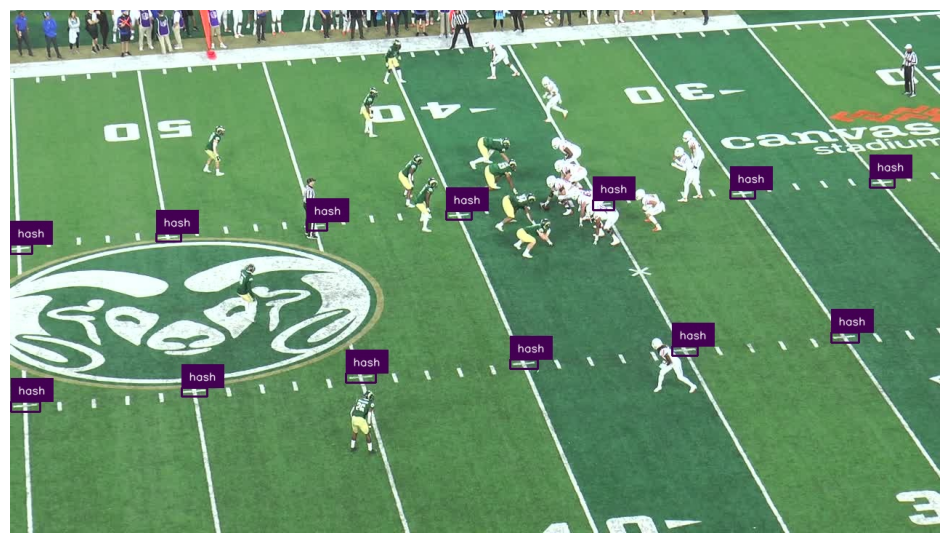

In [6]:
hash_mark_centers = detect_hash_marks(IMAGE_PATH, hash_marks_img)
hash_marks_vis = cv2.imread(hash_marks_img)
sv.plot_image(hash_marks_vis)

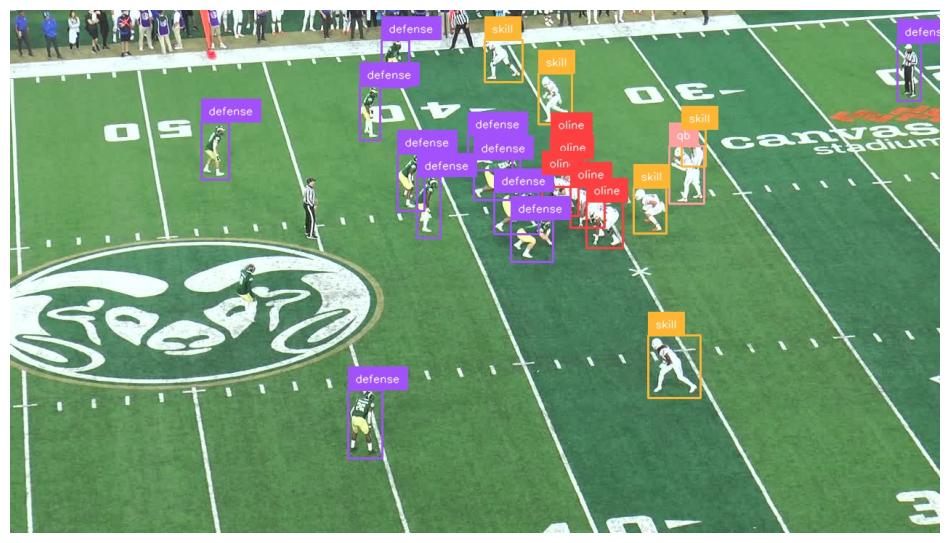

In [7]:
player_detections = detect_players(IMAGE_PATH, player_detections_img)
player_detections_vis = cv2.imread(player_detections_img)
sv.plot_image(player_detections_vis)

Initial players outside - Left: 0, Right: 1
Initial bounding lines at x: 178.1, 849.4
Total hash lines available: 6
Iteration 1: yard line amount: 5, distance: 25 feet
Players outside - Left: 0, Right: 1
Iteration 2: yard line amount: 6, distance: 30 feet
Players outside - Left: 0, Right: 0
Final yard line amount: 6, distance: 30 feet, iterations: 2


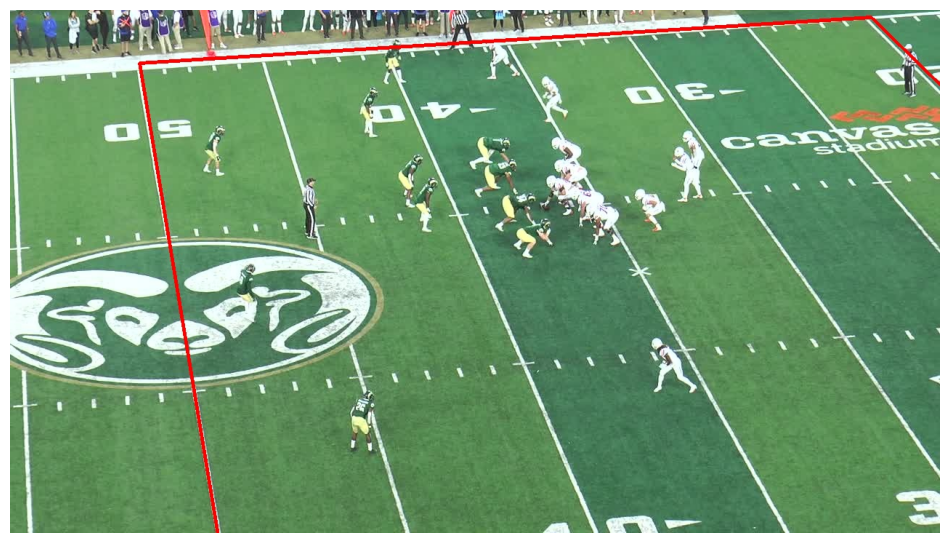

In [8]:
field_quad, yard_line_amount, yard_line_distance = process_full_field_bounds(
    IMAGE_PATH,
    field_boundaries_img,
    yard_lines,
    hash_mark_centers,
    player_detections,
    disable_estimation=False
)
field_boundaries_vis = cv2.imread(field_boundaries_img)
sv.plot_image(field_boundaries_vis)

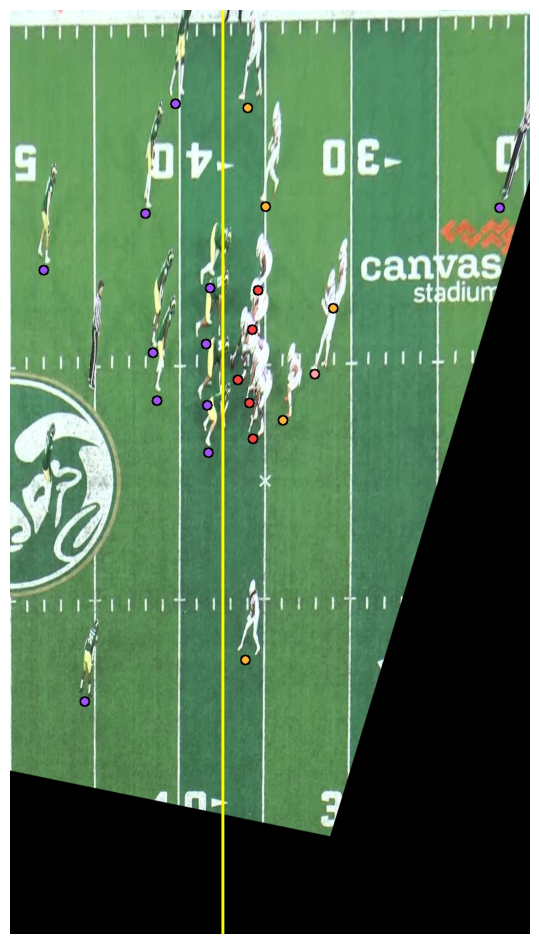

In [9]:
transformed_players, x_los = transform_image(IMAGE_PATH, top_down_perspective, annotated_top_down, field_quad, yard_line_distance, player_detections)

annotated_top_down_vis = cv2.imread(annotated_top_down)
sv.plot_image(annotated_top_down_vis)

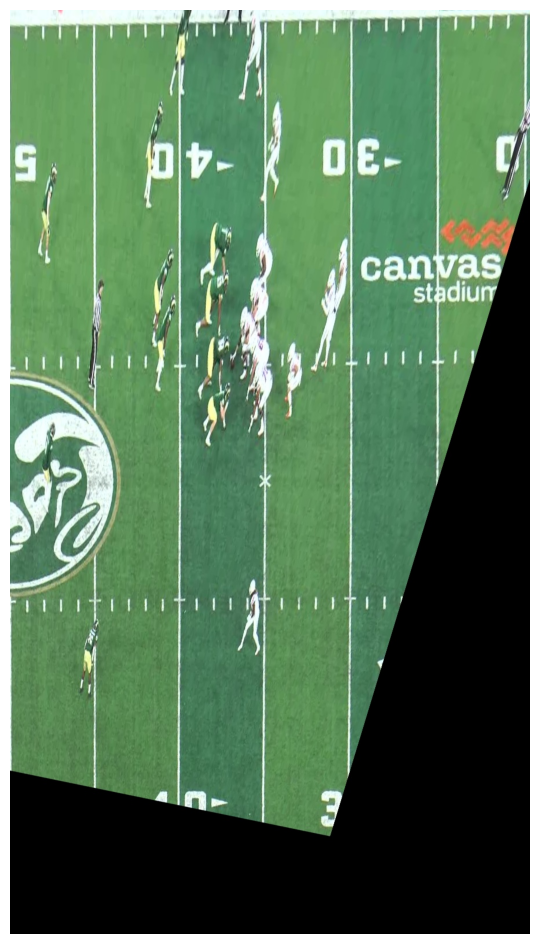

In [10]:
top_down_vis = cv2.imread(top_down_perspective)
sv.plot_image(top_down_vis)

2025-09-15 20:11:17,530 - FieldPositioning - DEBUG - Loaded template for number: BYU_1 from C:\Users\Justin.Getzke\IdeaProjects\football-pre-play-analysis\notebooks\..\src-python\resources\field_numbers\BYU_1.png
2025-09-15 20:11:17,531 - FieldPositioning - DEBUG - Loaded template for number: BYU_1_INV from C:\Users\Justin.Getzke\IdeaProjects\football-pre-play-analysis\notebooks\..\src-python\resources\field_numbers\BYU_1_INV.png
2025-09-15 20:11:17,531 - FieldPositioning - DEBUG - Loaded template for number: BYU_2 from C:\Users\Justin.Getzke\IdeaProjects\football-pre-play-analysis\notebooks\..\src-python\resources\field_numbers\BYU_2.png
2025-09-15 20:11:17,533 - FieldPositioning - DEBUG - Loaded template for number: BYU_2_INV from C:\Users\Justin.Getzke\IdeaProjects\football-pre-play-analysis\notebooks\..\src-python\resources\field_numbers\BYU_2_INV.png
2025-09-15 20:11:17,535 - FieldPositioning - DEBUG - Loaded template for number: BYU_3 from C:\Users\Justin.Getzke\IdeaProjects\foot

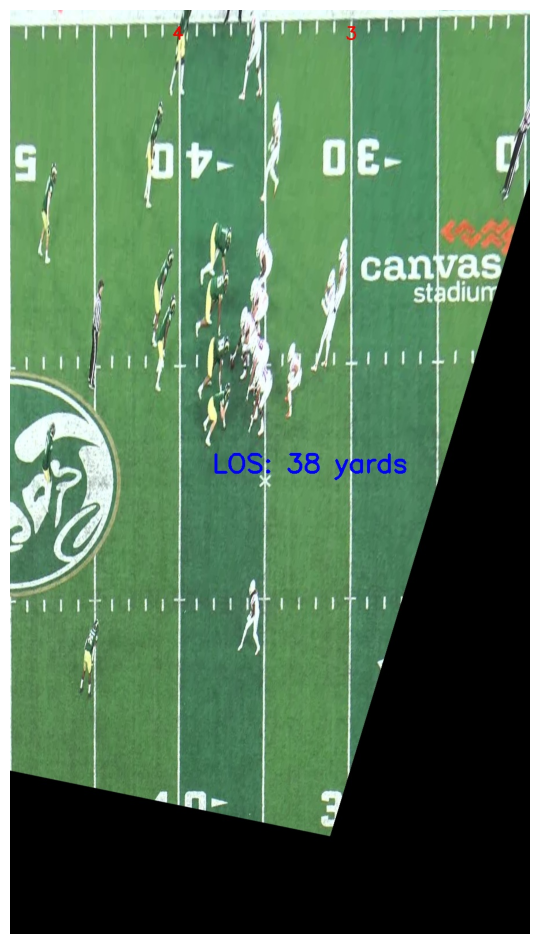

In [11]:
yard_line_numbers, los_yard, direction = classify_yard_lines_and_los(
    top_down_perspective,
    classified_yard_lines,
    x_los,
    threshold=0.75,
    numbers_dir=f"{src_path}/resources/field_numbers",
)
yard_numbers_img = cv2.imread(classified_yard_lines)
sv.plot_image(yard_numbers_img)

In [12]:
formation = classify_formation(formation_result, transformed_players, x_los, los_yard)
print(formation.label)

11 – 1x2 TE left [OFF]


2025-09-15 20:11:20,536 - ArtificialPitch - DEBUG - Output image path: C:\Users\Justin.Getzke\IdeaProjects\football-pre-play-analysis\notebooks\../src-python/resources/games/2108 BOISE STATE OFF vs COLORADO STATE/analysis\play_021_snap3_top_down_artificial.jpg
2025-09-15 20:11:20,536 - ArtificialPitch - DEBUG - Number of player positions: 22
2025-09-15 20:11:20,537 - ArtificialPitch - DEBUG - Line of scrimmage X (transformed): 368
2025-09-15 20:11:20,537 - ArtificialPitch - DEBUG - Line of scrimmage Y (yards): 38
2025-09-15 20:11:20,538 - ArtificialPitch - DEBUG - Direction: right
2025-09-15 20:11:20,564 - ArtificialPitch - DEBUG - Line of scrimmage X position in pixels: 2160


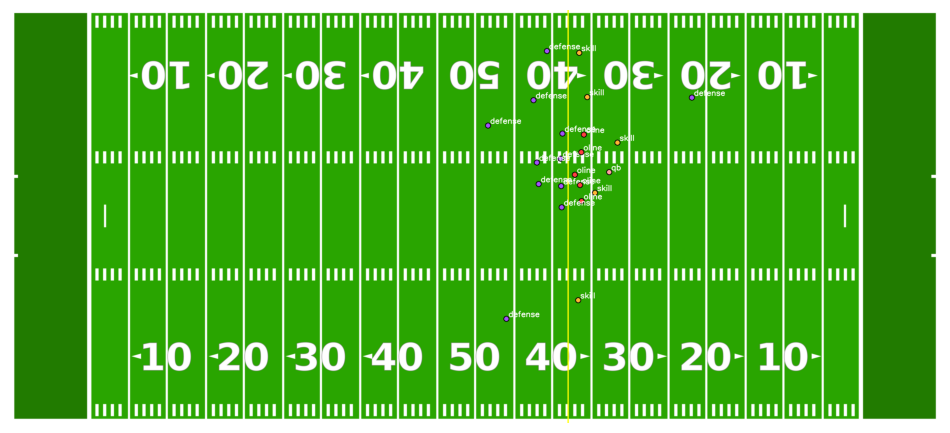

In [13]:
artificial_pitch_vis = draw_positions_on_artificial_pitch(
    artificial_pitch,
    transformed_players,
    x_los,
    los_yard,
    direction="left" if direction == 1 else "right",
    artificial_pitch_path=f"{src_path}/resources/artificial_pitch.png"
)
sv.plot_image(artificial_pitch_vis)